# Example 5.3 — LED Accelerated Degradation Analysis with Dual Stresses

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-09-29  
**Version:** 1.1  

---
## Problem Statement

In this accelerated degradation test (ADT), the light output of LED lamps is monitored over time [in hours]. The study follows the approach reported by (Pan and Crispin, 2011), focusing on how performance declines under different stress conditions. The stress factors are **ambient temperature** and **forward current**; these are controlled during testing, while the LED’s light output is periodically measured.

An LED is considered to have **failed** when its light output falls below **70%** of its initial luminous intensity, i.e., when the normalized performance level satisfies $D(t) < 0.70$.

**Normal use condition:** $T = 30^{\circ}\mathrm{C}$, $I = 400~\mathrm{mA}$.

**Test Conditions (Table 5.5)**

| Condition | $T$ (°C) | $I$ (mA) | No. of LEDs |
|:--------:|:--------:|:--------:|:-----------:|
| 1 | 77 | 700 | 8 |
| 2 | 77 | 500 | 14 |
| 3 | 45 | 700 | 14 |

## Degradation Model

Consider the following nonlinear model for the performance decline of LED luminosity:

$$
D_i\!\left(t_{ij}\right) \;=\; \left( 1 + c +\gamma \, t_{ij}^{b} \right)^{-1},
\qquad i=1,\dots,36,\quad j=1,\dots,4
$$

- $i$ indexes test units, $j$ indexes measurement instants.  
- $D_{i}$ is the normalized performance level (luminosity), with $D_{i}(0) = 1 + c$.  
- $\gamma$ is the degradation-rate term that depends on testing temperature and forward current.  
- $b$ is the time-shape parameter.
- $c$ is the offset on the damage term (controls vertical position of the curve)


With $\gamma$ represented with Arrhenius temperature and power-law current acceleration, the degradation model becomes:

$$
D(t, T, S)
= \left[
  1 + c + a \left(
    \exp\!\left(\frac{E_a}{k_B}
      \left(\frac{1}{T_{\text{use}}} - \frac{1}{T}\right)
    \right)
    \, S^{n} \, t
  \right)^{b}
\right]^{-1}.
$$


**Additional Parameters:**

- **$a$** – scale factor on the accumulated damage term  
- **$E_{a}$** – Arrhenius activation energy (eV)  
- **$n$** – power exponent on the second stress \(S\) (e.g. current in mA)  
- **$T_{\text{use}}$** – fixed use-level stresses (inputs, not fitted), and   
- **$k_{B}$**  - Boltzmann’s constant (**8.6174 × 10⁻⁵ eV·K⁻¹**) 
---

## Objective

Using **least squares (LSQ) and MLE**, **estimate the model parameters** from the performance degradation data summarized in Table 5.6, and **estimate the use life at the normal use condition $(T=30^{\circ}\mathrm{C}, I=400~\mathrm{mA})$** based on the **failure criterion $D(t)<0.70$.**

---

## Solution

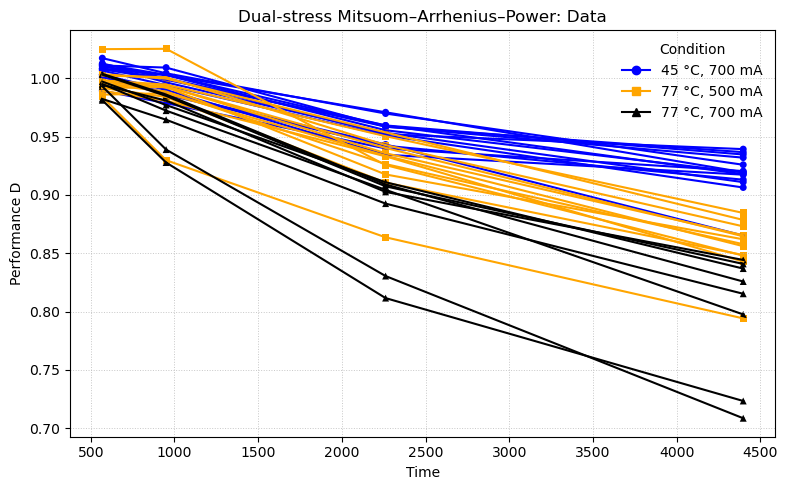

### Degradation / performance model (with offset)

**Model form (performance scale)**

This variant adds a vertical-offset parameter \(c\) to the Mitsuom model:

$$
D(t, T, S)
= \left[
  1 + c
  + a \left(
    \exp\!\left(\frac{E_a}{k_B}
      \left(\frac{1}{T_{\text{use}}} - \frac{1}{T}\right)
    \right)
    \, S^{n} \, t
  \right)^{b}
\right]^{-1}.
$$

The additional \(c\) term allows the starting performance level or
overall “height” of the degradation curve to shift slightly away from
exactly 1 while still maintaining \(1 + c > 0\).

**Parameters:**

- **$c$** – offset on the damage term (controls vertical position of the curve)  
- **$a$** – scale factor on the accumulated damage term  
- **$b$** – time/curvature exponent (how sharply degradation accelerates)  
- **$E_{a}$** – Arrhenius activation energy (eV)  
- **$n$** – power exponent on the second stress \(S\) (e.g. current in mA)  
- **$T_{\text{use}}, S_{\text{use}}$** – fixed use-level stresses (inputs, not fitted)

### LSQ (95% CI)

| Parameter | Estimate | SE | 95% CI |
|-----------|----------|----|--------------|
| a | 1.47565e-06 | 2.556e-05 | [-4.862e-05, 5.157e-05] |
| b | 0.807756 | 1 | [-1.152, 2.768] |
| Ea (eV) | 0.242099 | 1 | [-1.718, 2.202] |
| n | 0.81703 | 1 | [-1.143, 2.777] |
| c | -0.0394315 | 1 | [-1.999, 1.921] |

**Noise D:** 0.0229155


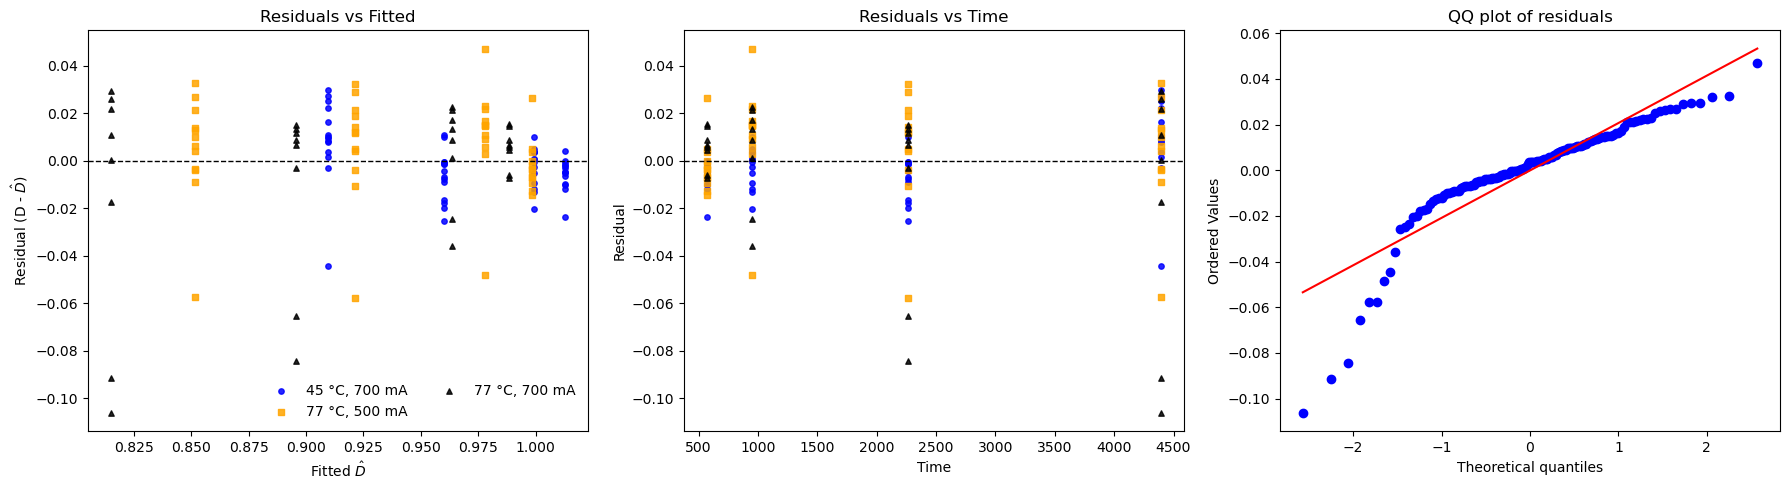


Estimated life at use (30 °C, 400 mA) for Df=0.7: t_med ≈ 4.84e+04 time units


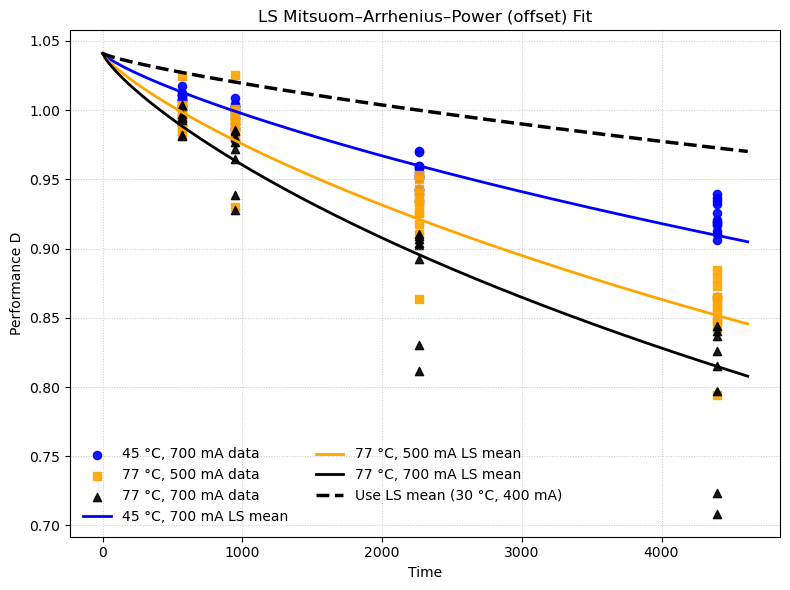

In [5]:
# EXAMPLE 5.3
import pandas as pd
import sys 
sys.path.append("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/ADT Fitters Module")
df = pd.read_csv("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/Modarres Chapter Validation/data/Example_5.3_LED_degradation_data.csv")

# Remove outlier units
df = df[~df["Unit"].isin([15, 22])].reset_index(drop=True)  #[15, 22]

# --- Tidy to long format: (Unit, T_C, I_mA, time_hr, D) ---
time_cols = [c for c in df.columns if "(hr)" in c]
df = df.melt(id_vars=["Unit", "T_C", "I_mA"], value_vars=time_cols, var_name="time_hr", value_name="D").dropna()
df["time_hr"] = df["time_hr"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)
df = df.sort_values(["Unit", "time_hr"]).reset_index(drop=True)

T_use_C = 30    # deg C
I_use_mA = 400  # mA
Df = 0.70       # relative luminosity

from ADT_fitters import Fit_ADT_Mitsuom_Arrhenius_Power
fit_dual = Fit_ADT_Mitsuom_Arrhenius_Power(
    degradation=df["D"],
    temp_C=df["T_C"],
    stress_S=df["I_mA"], 
    time=df["time_hr"],
    unit=df["Unit"],
    stress_use_T=T_use_C,
    stress_use_S=I_use_mA, 
    Df=Df,
    CI=0.95,
    method="LS",
    show_data_plot=True,
    show_LSQ_diagnostics=True,
    print_results=True,
)

from ADT_fitters import Fit_ADT_Mitsuom_Arrhenius_Power1
fit_dual = Fit_ADT_Mitsuom_Arrhenius_Power1(
    degradation=df["D"],
    temp_C=df["T_C"],
    stress_S=df["I_mA"], 
    time=df["time_hr"],
    unit=df["Unit"],
    stress_use_T=T_use_C,
    stress_use_S=I_use_mA, 
    Df=Df,
    CI=0.95,
    method="LS",
    show_data_plot=True,
    show_LSQ_diagnostics=True,
    print_results=True,
)

### Degradation / performance model (with offset)

**Model form (performance scale)**

This variant adds a vertical-offset parameter \(c\) to the Mitsuom model:

$$
D(t, T, S)
= \left[
  1 + c
  + a \left(
    \exp\!\left(\frac{E_a}{k_B}
      \left(\frac{1}{T_{\text{use}}} - \frac{1}{T}\right)
    \right)
    \, S^{n} \, t
  \right)^{b}
\right]^{-1}.
$$

The additional \(c\) term allows the starting performance level or
overall “height” of the degradation curve to shift slightly away from
exactly 1 while still maintaining \(1 + c > 0\).

**Parameters:**

- **$c$** – offset on the damage term (controls vertical position of the curve)  
- **$a$** – scale factor on the accumulated damage term  
- **$b$** – time/curvature exponent (how sharply degradation accelerates)  
- **$E_{a}$** – Arrhenius activation energy (eV)  
- **$n$** – power exponent on the second stress \(S\) (e.g. current in mA)  
- **$T_{\text{use}}, S_{\text{use}}$** – fixed use-level stresses (inputs, not fitted)

### MLE (additive) (95% CI)

| Parameter | Estimate | SE | 95% CI |
|-----------|----------|----|--------------|
| a | 1.82541e-08 | 238.8 | [-468, 468] |
| b | 0.95098 | 10.52 | [-19.66, 21.56] |
| Ea (eV) | 0.261726 | 4.784 | [-9.115, 9.638] |
| n | 1.17033 | 8.896 | [-16.27, 18.61] |
| c | -0.0261961 | 1.383 | [-2.737, 2.684] |

**Noise D:** 0.0217464


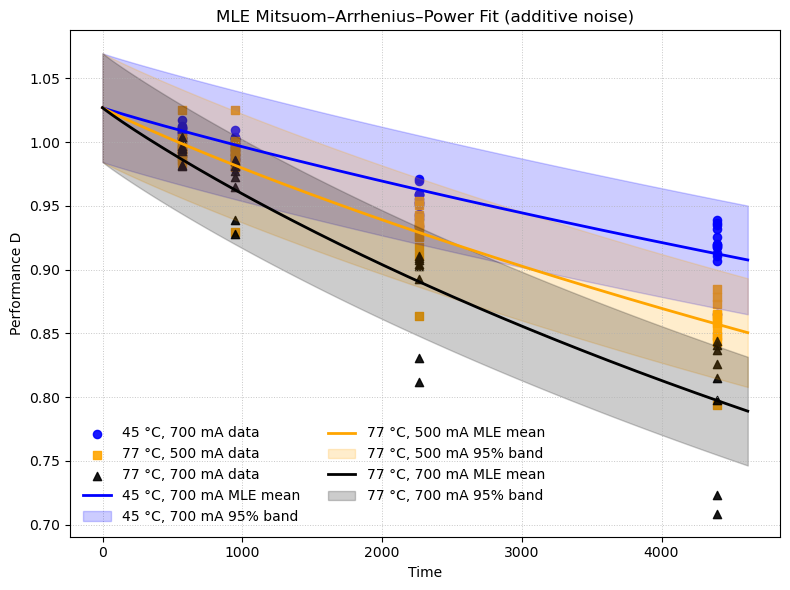

### Posterior summary for TTF at use (30 °C, 400 mA, Df=0.7, MLE plug-in)

- Mean life: 5.4321e+04 time units
- Median life: 5.4098e+04 time units
- 95% HDI: [4.3593e+04, 6.5624e+04] time units
- 95% ETI: [4.3798e+04, 6.5894e+04] time units

c:\users\leaat\reliability\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 8000/0 (0% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1 DS      Mu   Sigma     Lambda  Log-likelihood   AICc    BIC       AD optimizer
   Lognormal_2P                                                                         10.8973 0.10405                   -80426.7 160857 160871  1.72437  L-BFGS-B
   Lognormal_3P                       0                                                 10.8973 0.10405                   -80426.7 160859 160880  1.72437       TNC
      Normal_2P                                                                         54321.2 5630.37                     -80439 160882 160896  2.94694       TNC
     Weibull_3P 20028.6  3.4844 36286.6                                                                                   -80457.3 160921 160942  6.18816       TNC
 Loglogistic_2P 54095.7 16.8105                                           

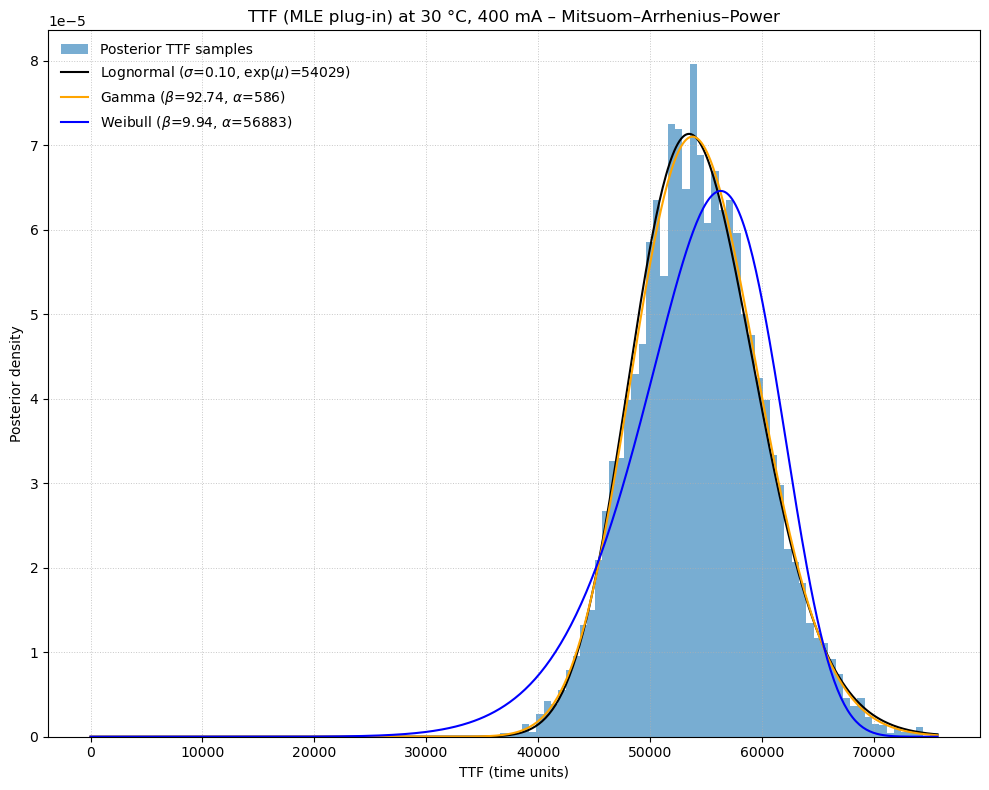

In [12]:
from ADT_fitters import Fit_ADT_Mitsuom_Arrhenius_Power1
fit_dual = Fit_ADT_Mitsuom_Arrhenius_Power1(
    degradation=df["D"],
    temp_C=df["T_C"],
    stress_S=df["I_mA"], 
    time=df["time_hr"],
    unit=df["Unit"],
    stress_use_T=T_use_C,
    stress_use_S=I_use_mA, 
    Df=Df,
    CI=0.95,
    method="MLE",
    noise="additive",
    show_data_plot=False,
    show_use_TTF_dist=True,
    print_results=True,
)